In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
#from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import sqlite3
from random import randint

I propose that the worst performance for ACI will be when the distribution changes at the same intervals as the lookback window as at that point there is a gaurantee that the quantile will be estimated with data which is not relevant to the now current distribution.

In [2]:
dist_period =100

In [3]:
# This creates a TS, where the distribution changes at different points deppending on a provided list of distribution shifts.
def Create_TimeSeries(dist_shifts):
    final = np.array([])
    
    for i in range(len(dist_shifts)):
        Y = abs(np.random.normal(dist_shifts[i][0], dist_shifts[i][1], dist_period))
        final = np.concatenate((final, Y))
    
    return final + 0.5*np.roll(final, 1)

# Generating the data.

In [4]:


p = 0.5
pdist, steps = [1-p, p], [-1, 1]

datapoints = 20

train_Output = []

# These are the distribution shifts that will be applied to the time series
dist_shift = [(randint(-10, 10), randint(1, 10)) for _ in range(10)]
#dist_shift = [(0,1), (2,0)]
#dist_shift = [((-1**x) * 100, 100) if x%5==0 else (0, 0) for x in range(30)]

for _ in range(datapoints):
    X =  np.random.choice(steps, size=len(dist_shift)*dist_period, p=pdist)
    Y = Create_TimeSeries(dist_shift)
    T = np.cumsum(X*Y)
    
    input_data = T[:-1]
    labels_data = T[1:]

    train_Output.append((input_data, labels_data))


In [6]:
# This function predicts a range of Y_t at the alpha level. By using alpha_t.
def C_t(alpha_t, scores, sigma_t, t):
    alpha_t = min(1, max(0, alpha_t))
    Q = np.quantile(scores[t-50:t], 1 - alpha_t)
    positve_v = (sigma_t) + (abs(sigma_t) * Q)
    negative_v = (sigma_t) - (abs(sigma_t) * Q)
    return negative_v, positve_v

# This function returns 1 if the prediction lies in the interval, 0 otherwise.
def err_t(Y_t, C_t):
    if C_t[0] < Y_t < C_t[1]:
        return 0
    else:
        return 1

def plots(error_list, coverage, range_list, alpha_list, y): 
    _, axs = plt.subplots(2, 2, figsize=(30, 10))

    axs[0][0].plot(1 - pd.Series(error_list).rolling(50).mean())
    axs[0][0].axhline(coverage, color='r', linestyle='--')
    for i in range(0, len(y), dist_period):
        axs[0][0].axvline(max(0, i-50), color='g', linestyle='--')
    #axs[0][0].plot(alpha_list,label='our alpha')

    axs[0][0].set_title('Coverage')
    
    axs[0][1].plot([ele[0] for ele in range_list], label='Lower')
    axs[0][1].plot([ele[1] for ele in range_list], label='Upper')
    axs[0][1].plot(y[51:])
    for i in range(0, len(y), dist_period):
        axs[0][1].axvline(max(0, i-50), color='r', linestyle='--')
    axs[0][1].set_title('Prediction')
    axs[0][1].legend()

    axs[1][0].plot([ele[1]-ele[0] for ele in range_list], label='Distance')
    axs[1][0].axhline(np.mean([ele[1]-ele[0] for ele in range_list]), color='r', linestyle='--')
    axs[1][0].legend()
    axs[1][0].set_title('Distance between upper and lower bounds')

    axs[1][1].plot(alpha_list,label='our alpha')
    axs[1][1].axhline(0.5, color='r', linestyle='--')
    axs[1][1].axhline(np.mean(alpha_list), color='g', linestyle='--')
    axs[1][1].legend()
    axs[1][1].set_title('Alpha')

    plt.show()

    return None

In [7]:
def ACI(alpha, input_gamma, train_Output, Isplots=False):
    alpha = alpha
    orignal_alpha = alpha 
    gamma = input_gamma

    total_coverage_list = []

    for m, (xpred, y) in enumerate(train_Output):
        # Getting the prediction and the actual value.
        
        # Calculating the scores at each time step
        All_scores = (abs(y - xpred))/abs(xpred)

        error_list = []
        range_list = []
        alpha_list = []
        
        for i in range(51, len(All_scores)):
            # This is inclusive of i
            Coverage_t = C_t(alpha, All_scores, xpred[i], i)
            range_list.append(Coverage_t)

            error_t = err_t(y[i], Coverage_t)
            error_list.append(error_t)

            alpha = min(max(alpha + (gamma * (orignal_alpha - error_t)), 0), 1)
            alpha_list.append(alpha)


        coverage = 1 - pd.Series(error_list).rolling(50).mean().mean()
        total_coverage_list.append(coverage)
        
        if m<10 and Isplots:
            plots(error_list, coverage, range_list, alpha_list, y)
            
        yield error_list, range_list, alpha_list
  

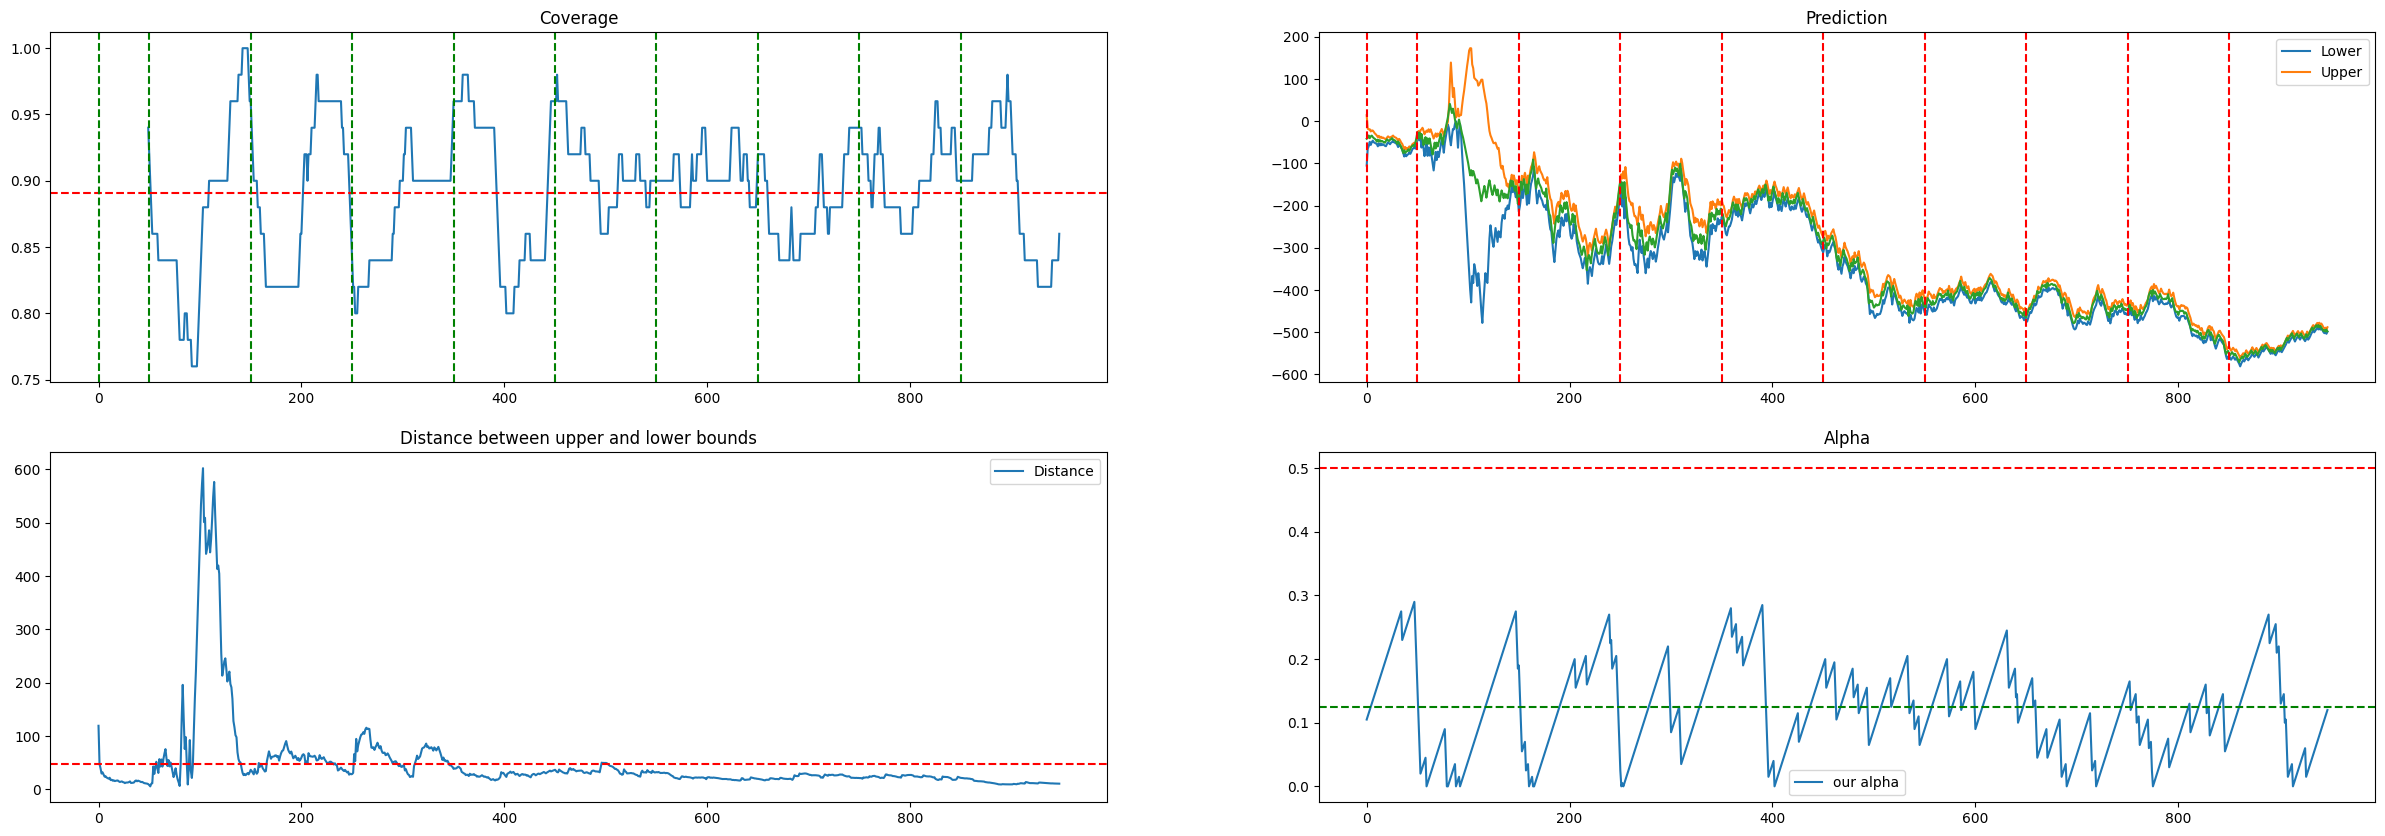

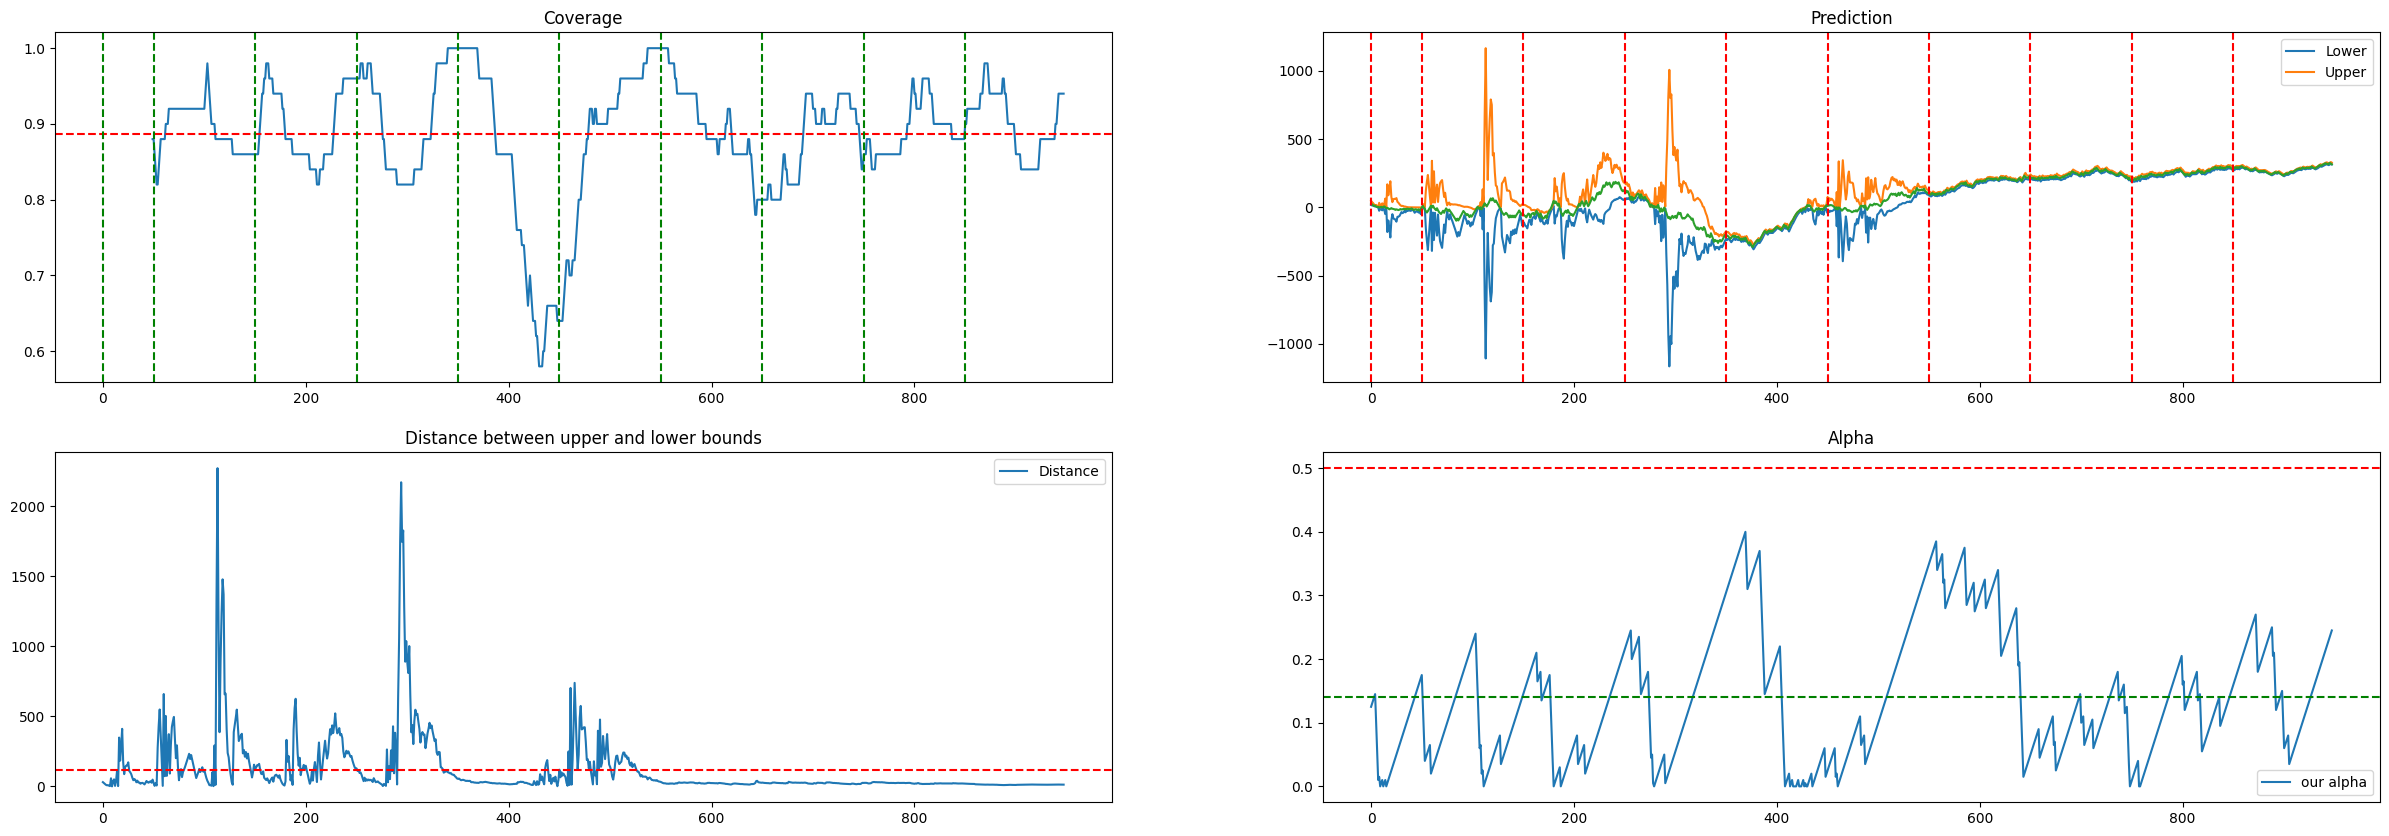

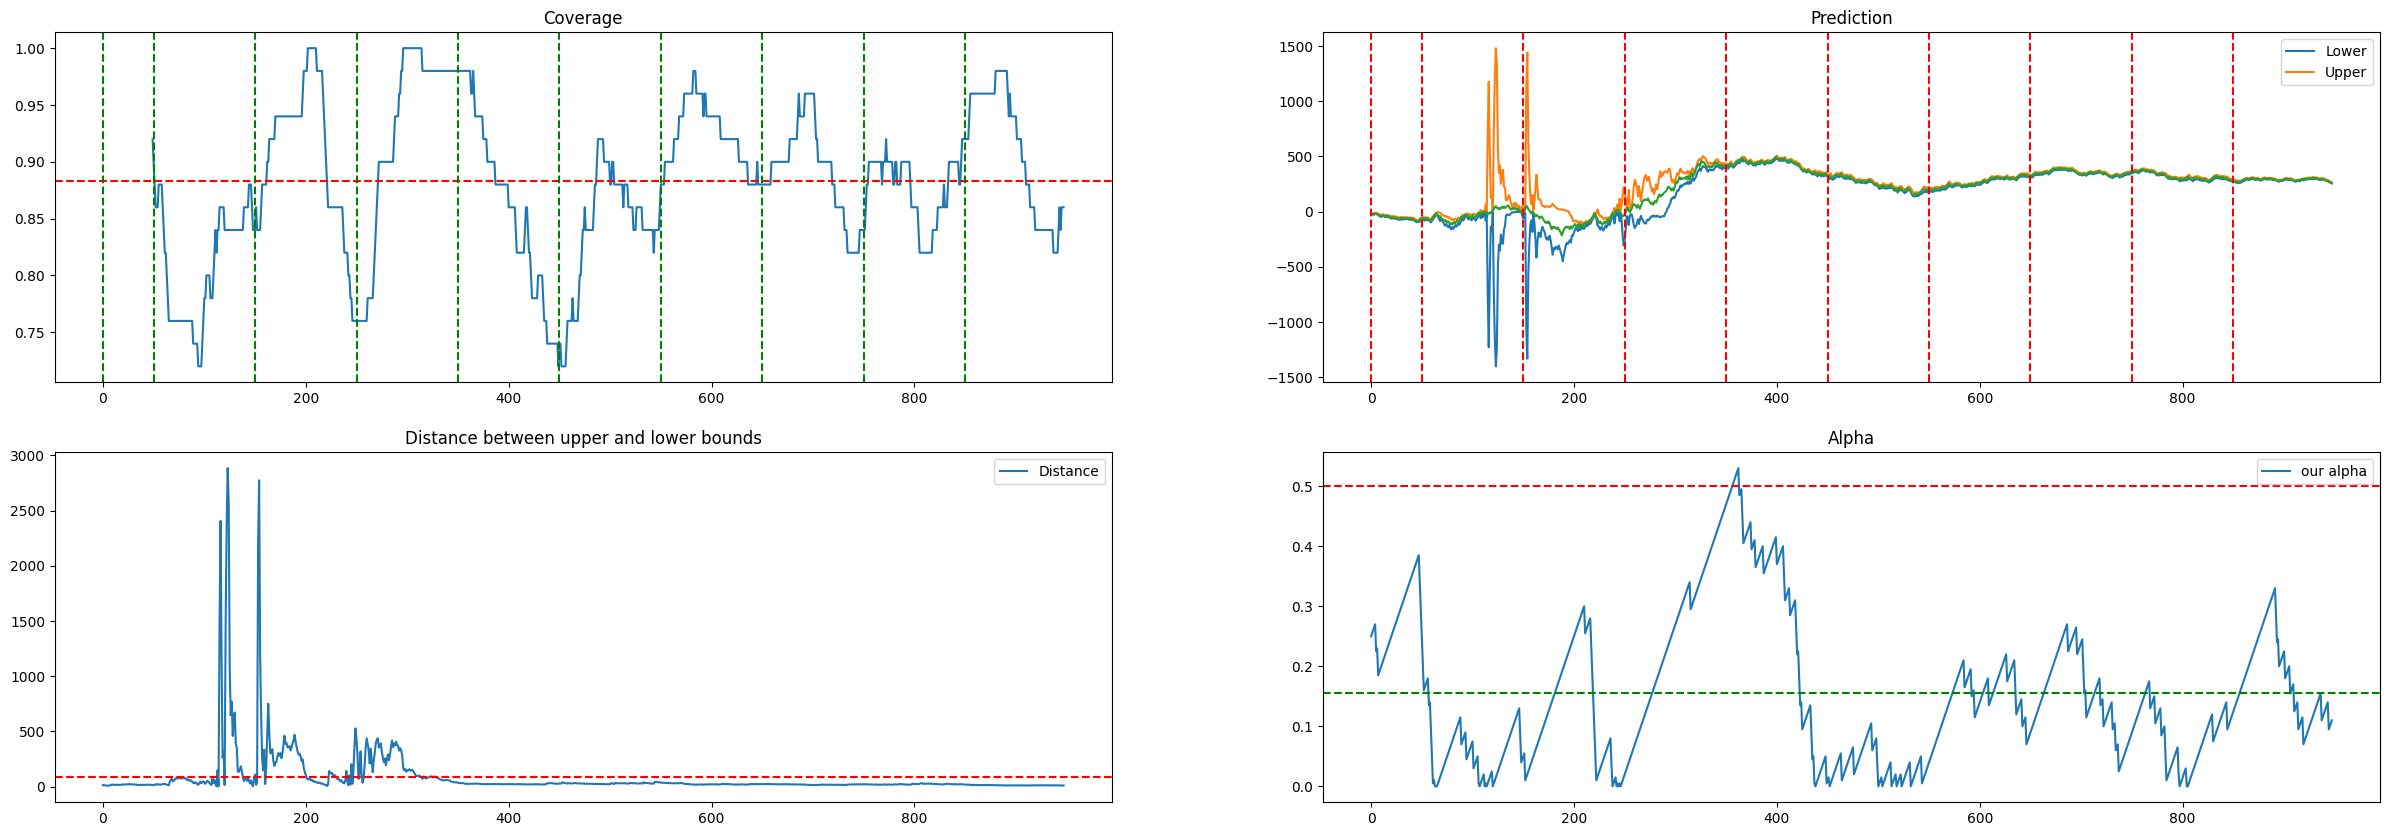

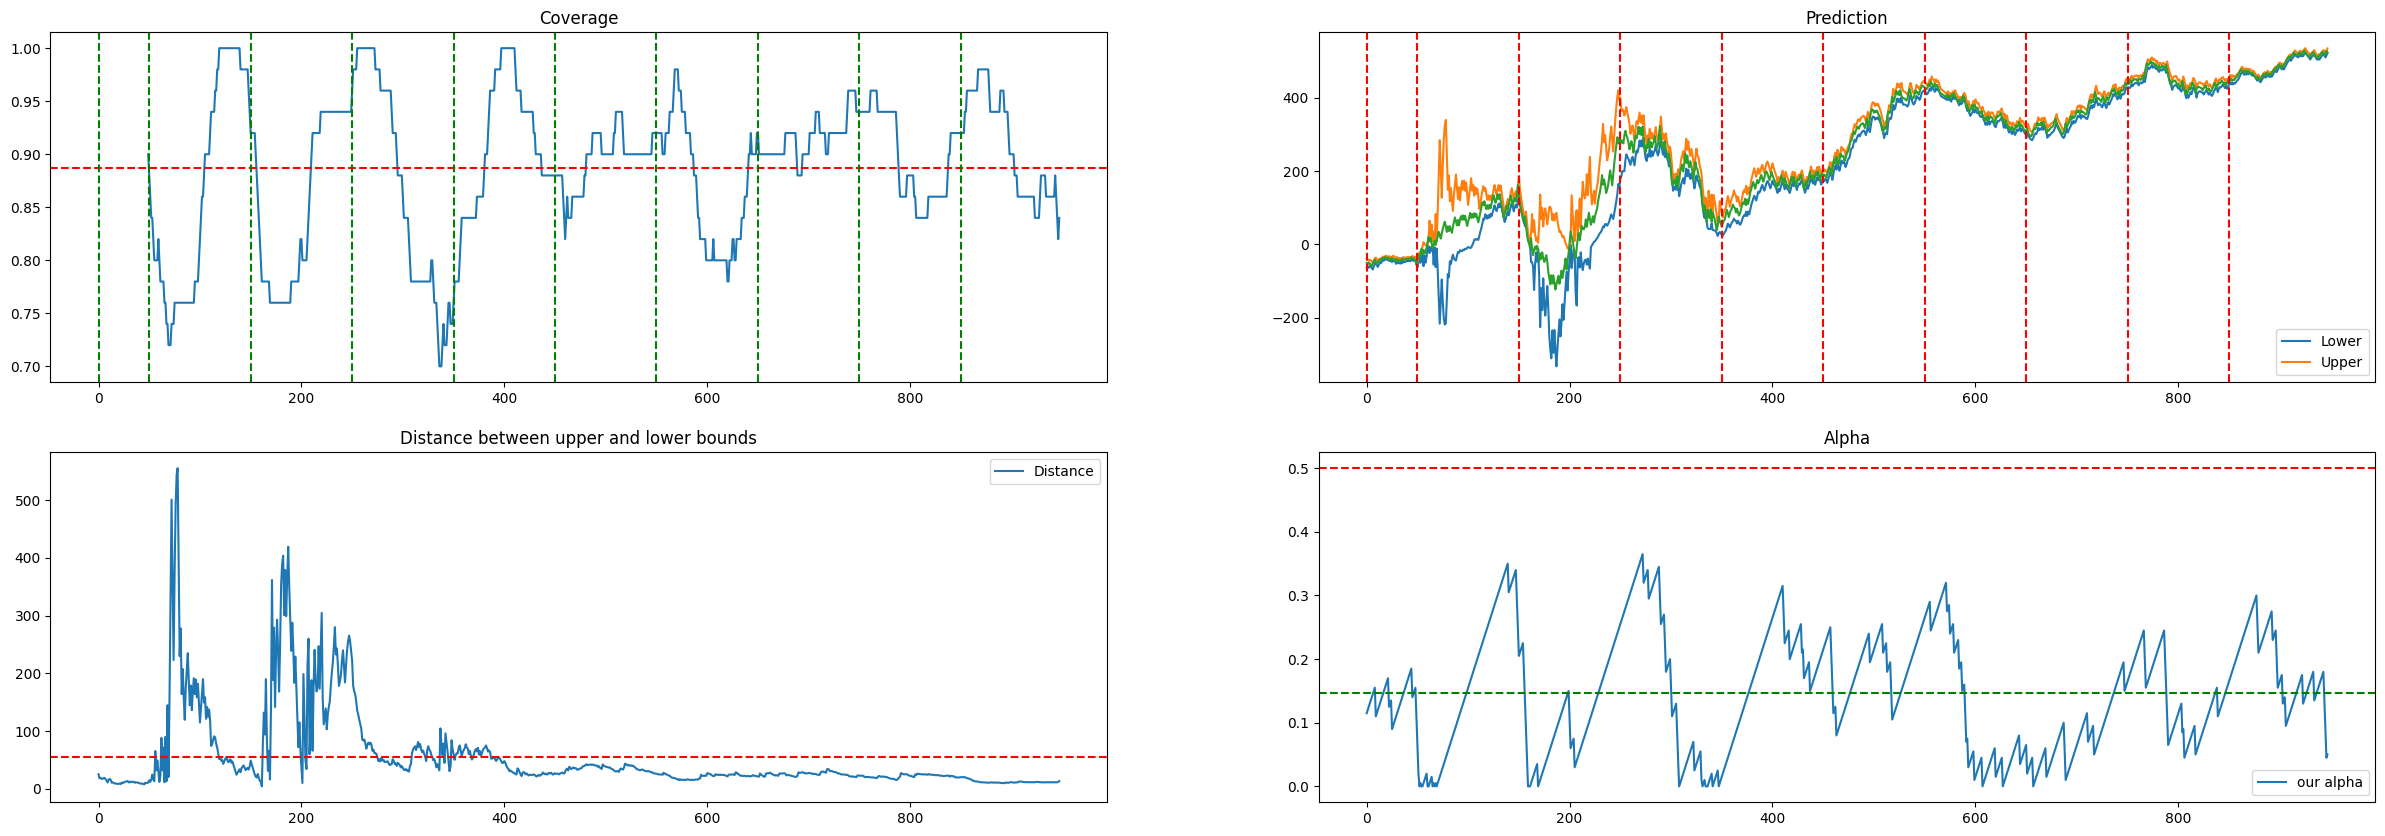

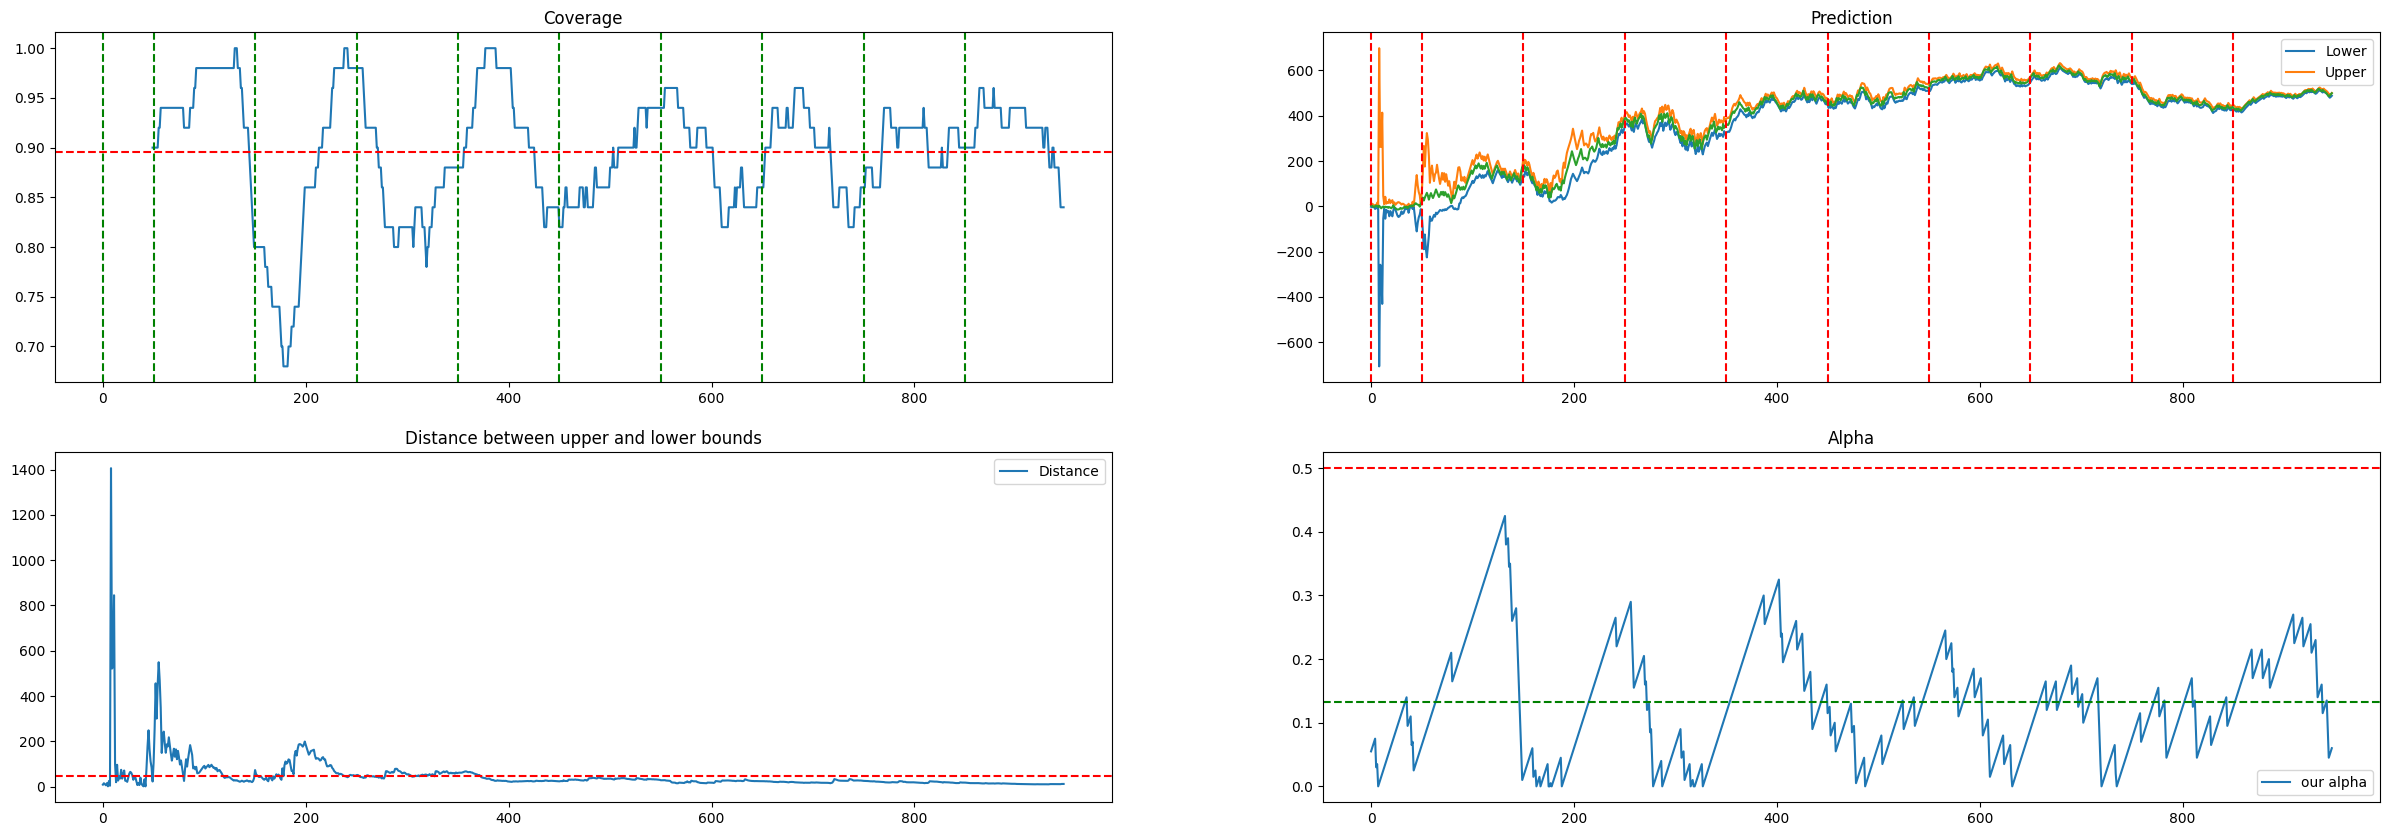

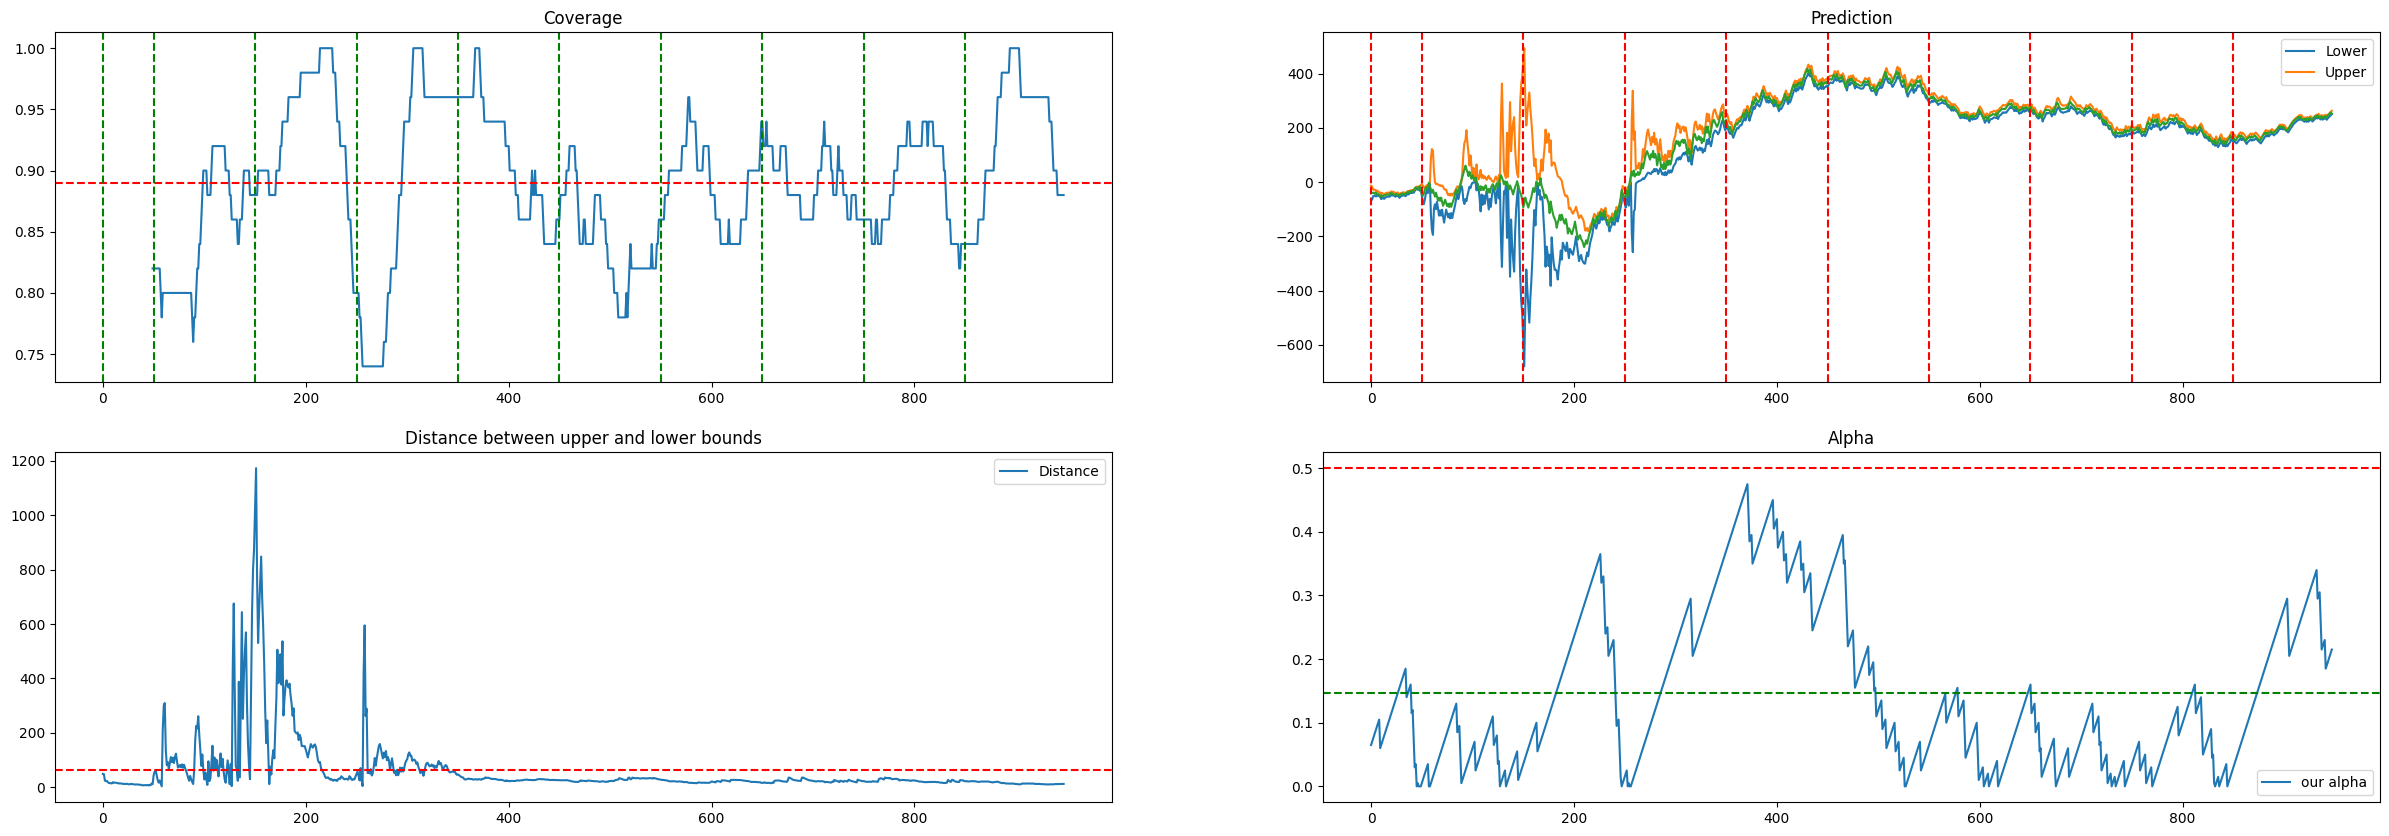

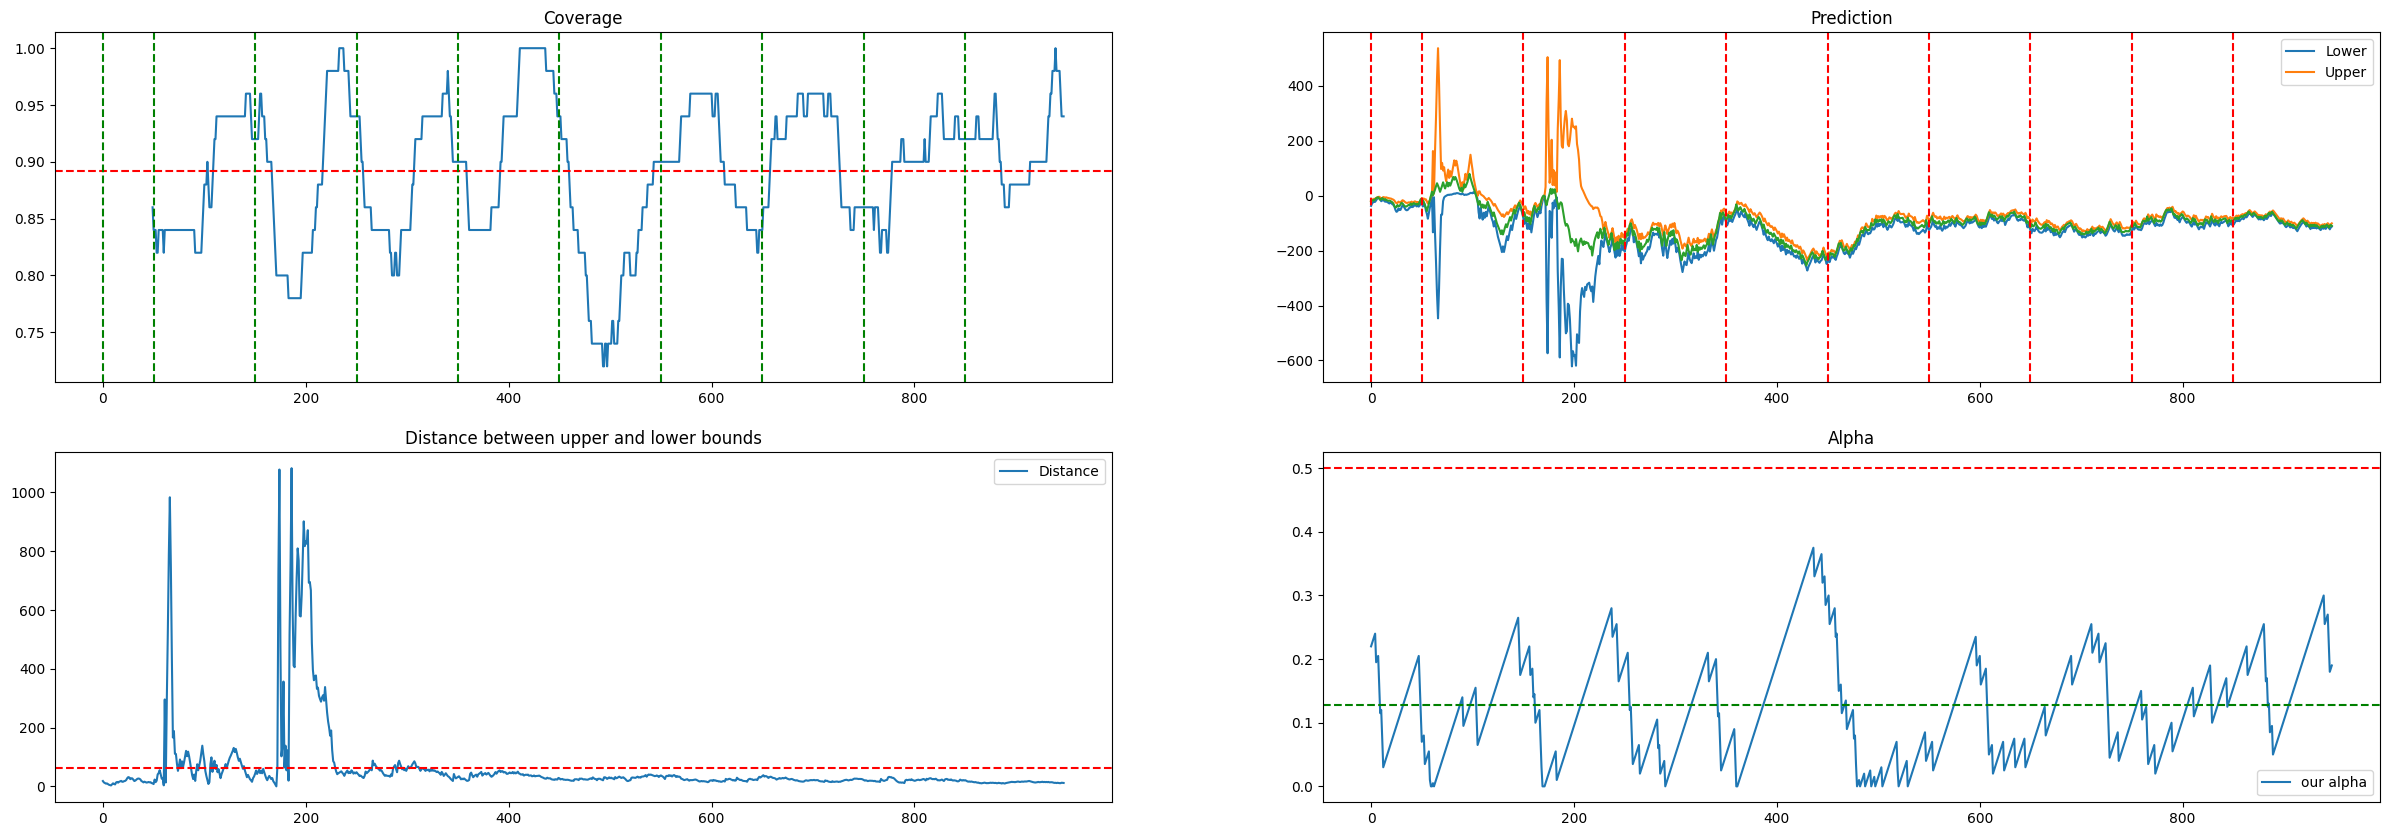

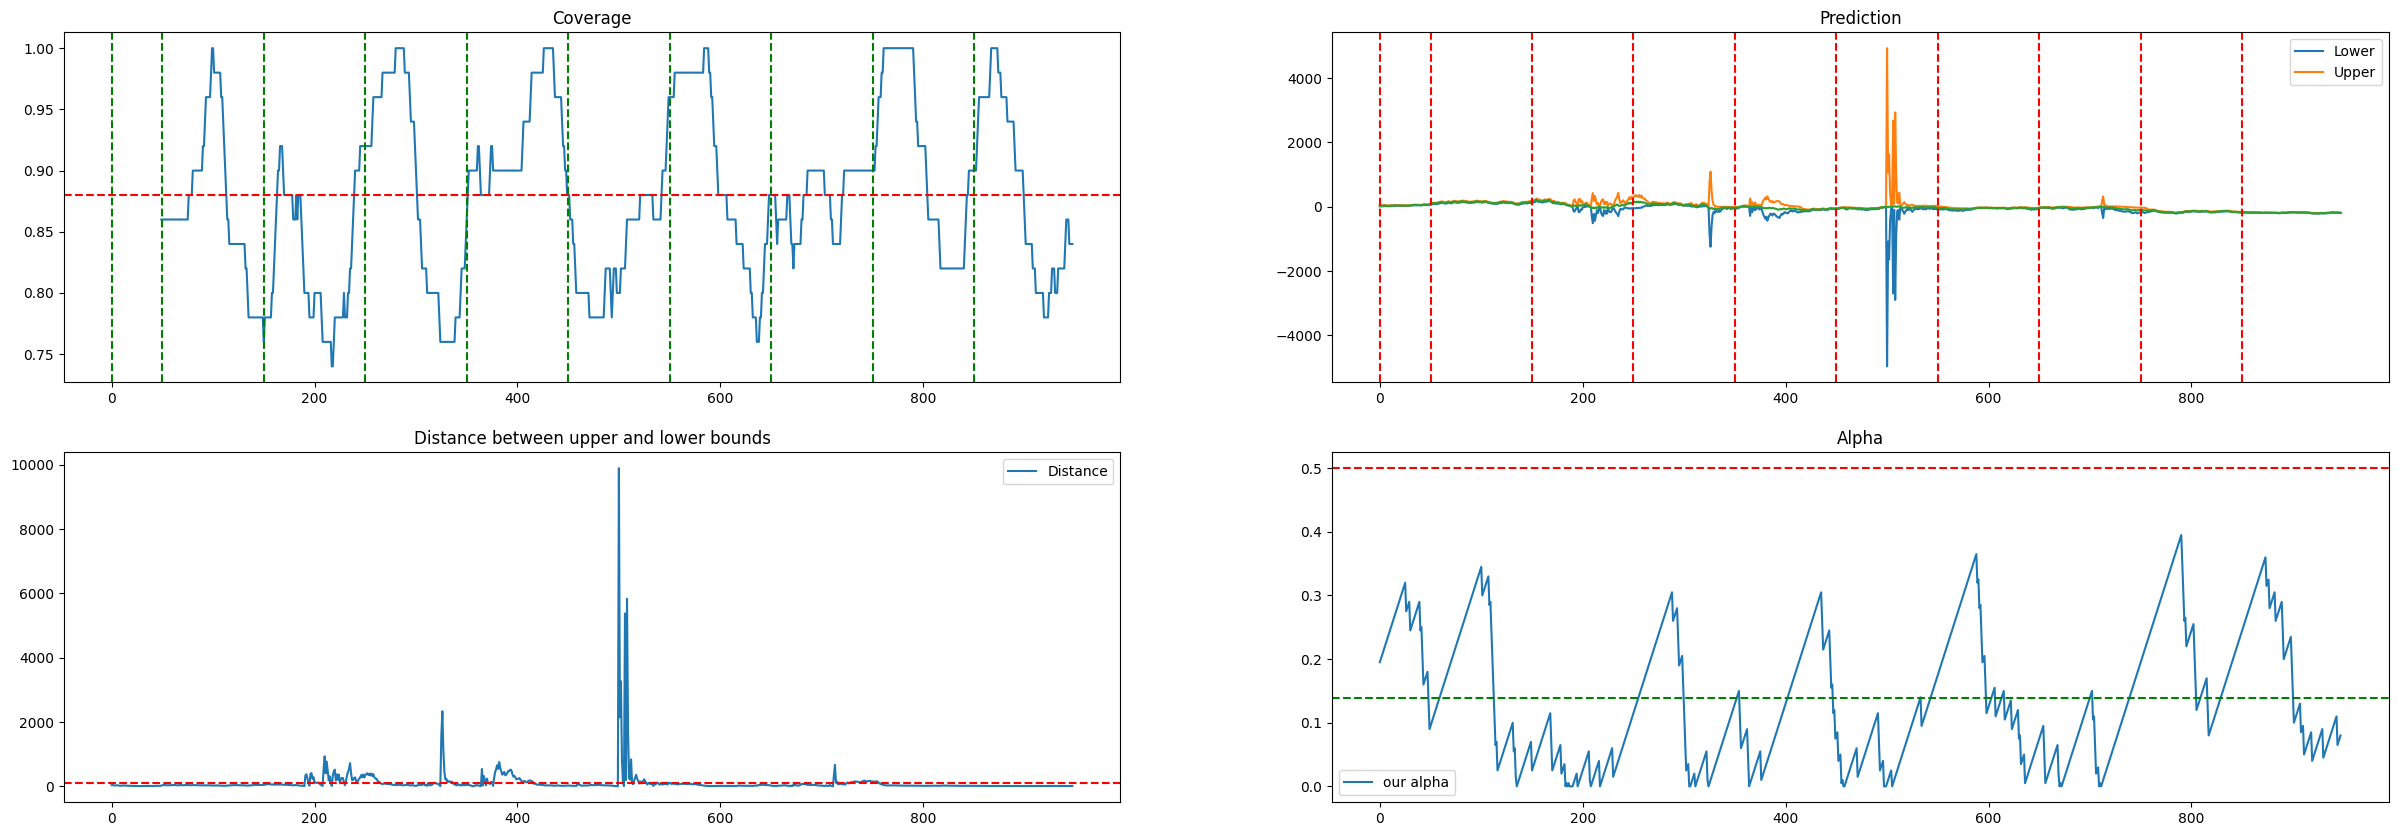

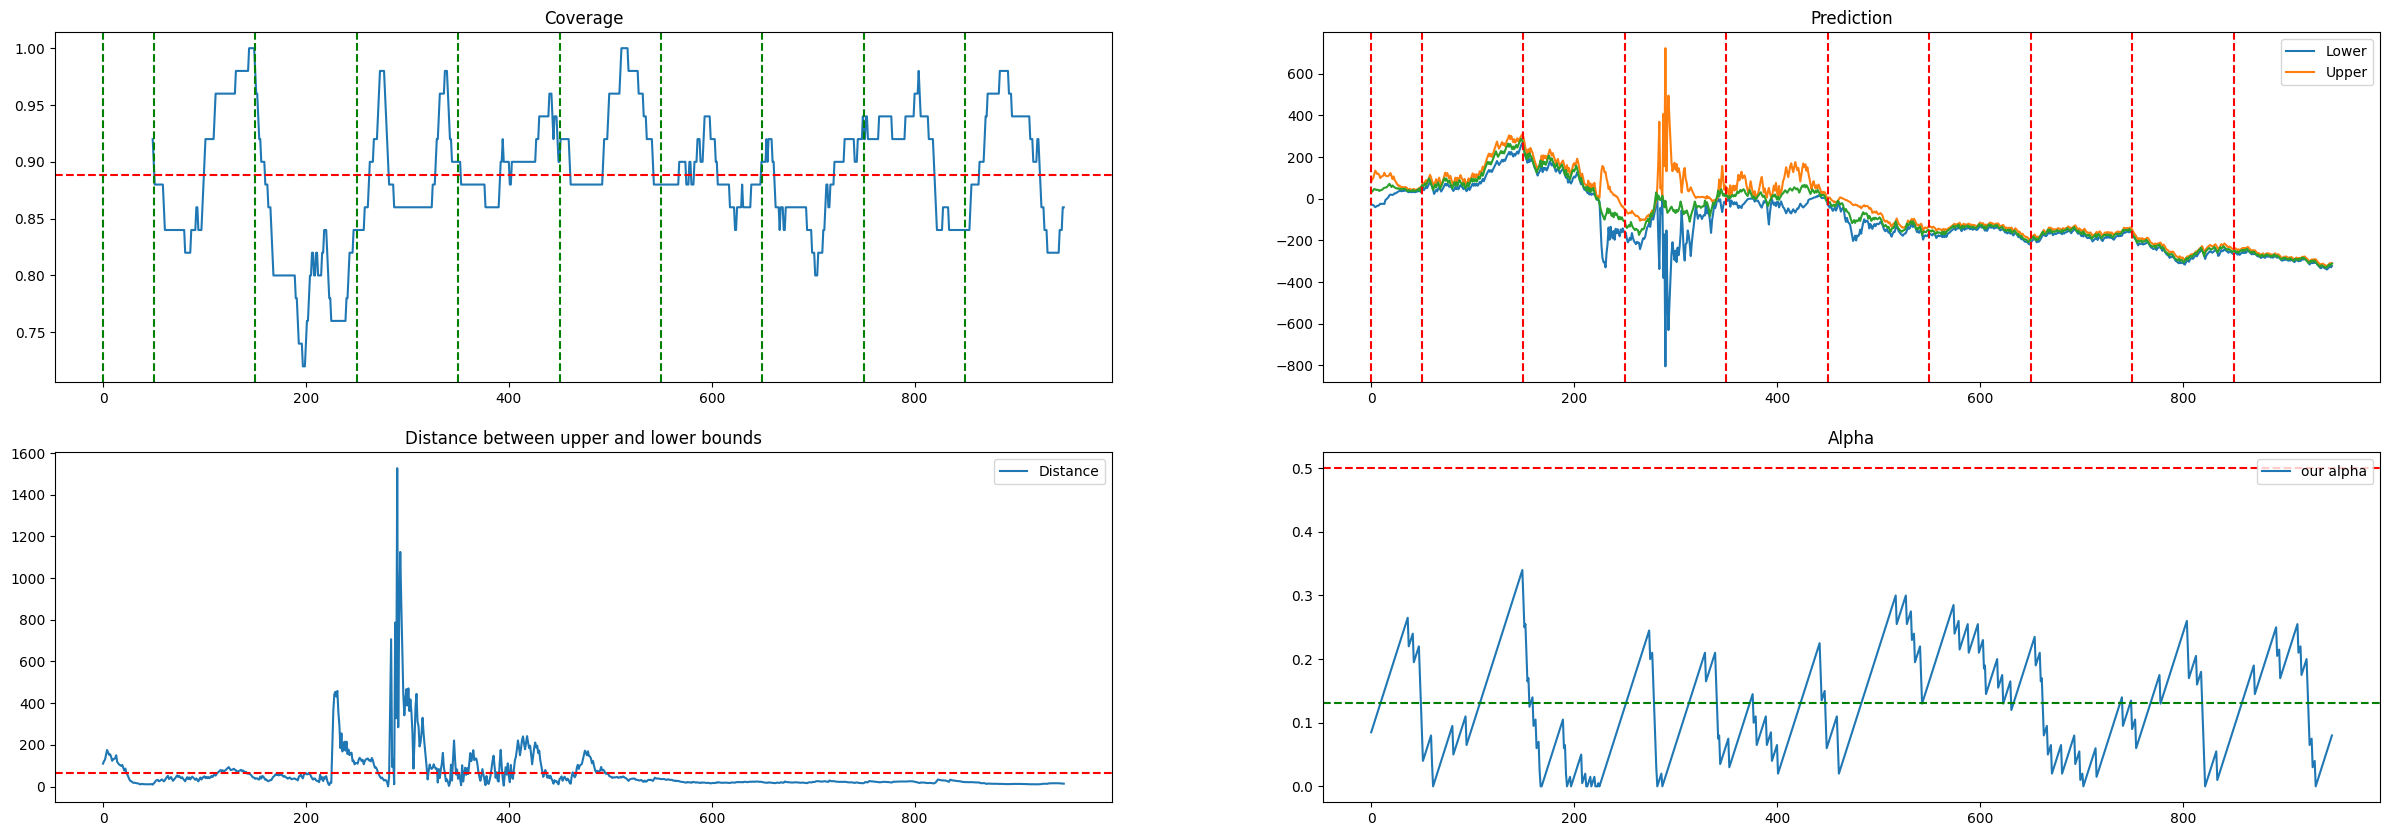

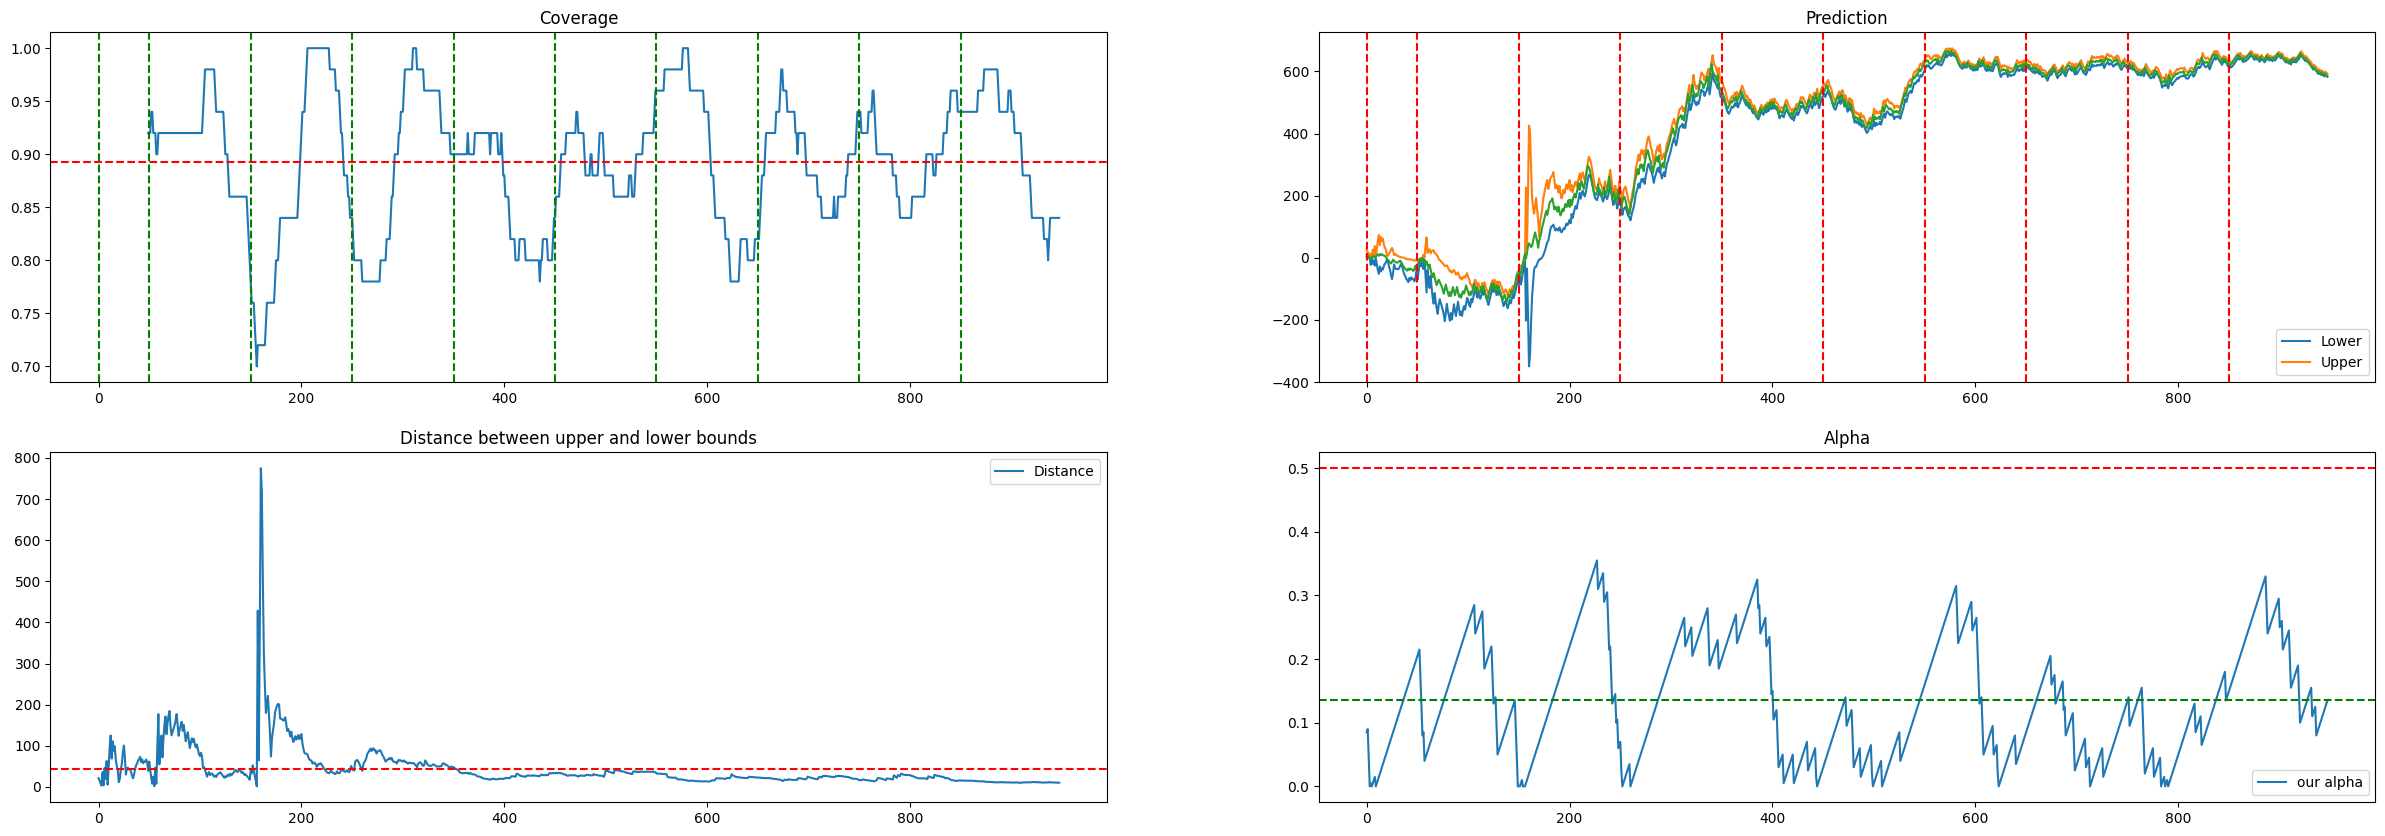

In [8]:
ACI_gen = ACI(0.1, 0.05, train_Output, True)
for _ in range(10):
    next(ACI_gen)

Observed that sometimes. prob due to beng unluck we have that one weight gets over assigned probabilty and then it gets chosen almost every time which can cause a terrible result which throws of the entire average. Am also noticing that the variamce is of dtaci is consittently lower which supports the hypothesis that it is not correctig its mistakes.

Also the fact that there is chanve involved means that sometimes a clearly bad weight is chosen by chance.